# Installs and Imports

In [1]:
!pip install matplotlib
!pip install seaborn

     |████████████████████████████████| 292 kB 6.8 MB/s eta 0:00:01
     |████████████████████████████████| 11.5 MB 5.8 MB/s eta 0:00:01    |███████▍                        | 2.7 MB 3.0 MB/s eta 0:00:03


In [2]:
# Fenics imports:
import dolfinx
import dolfinx.plot
import ufl

# Numerics imports:
from mpi4py import MPI
from petsc4py import PETSc
import numpy as np

# Visualisation imports:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Misc imports:
from math import sin, cos, pi, ceil, floor
import os
import json
import itertools
import time

In [3]:
# Set plotting settings:
mpl.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

# FEM Code Functions

## Main Subroutine

In [3]:
def solve_nonlinear_problem(mesh, y_rot, x_rot, E, kappa, nu, rho, g, num_steps, el_order=2, rtol=1e-3, atol=1e-3, max_it=10):

    # Create function space:
    V = dolfinx.VectorFunctionSpace(mesh, ("CG", el_order))

    bcs = create_bcs(mesh, V)
    
    F, u, B = create_constitutive_eqn(E, nu, kappa, mesh, V)
    
    # Delete cache of previous models:
    !rm -r /root/.cache/fenics/*
    
    # Define problem:
    problem = dolfinx.fem.NonlinearProblem(F, u, bcs)
    solver = dolfinx.NewtonSolver(MPI.COMM_WORLD, problem)
    solver.rtol = rtol
    solver.atol = atol
    solver.max_it = max_it
    
    f = create_load_vector(y_rot, x_rot, rho, g)
    u = perform_load_stepping(solver, u, B, f, num_steps)
    
    # Compute volume of mesh before and after deformation:
    volumes = compute_volumes(u, mesh)
    
    return (u, volumes)

## Mesh + BCs

In [4]:
def create_mesh(L, W, NL, NW):
    mesh = dolfinx.BoxMesh(MPI.COMM_WORLD,[[0.0,0.0,0.0], [L, W, W]], [NL, NW, NW], dolfinx.cpp.mesh.CellType.hexahedron)
    return mesh

In [5]:
def create_bcs(mesh, V):
    fixed = lambda x: np.isclose(x[0], 0)
    fixed_facets = dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, fixed)
    facet_tag = dolfinx.MeshTags(mesh, mesh.topology.dim-1, fixed_facets, 1)
    u_bc = dolfinx.Function(V)
    with u_bc.vector.localForm() as loc:
        loc.set(0)
    left_dofs = dolfinx.fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.indices[facet_tag.values==1])
    bcs = [dolfinx.DirichletBC(u_bc, left_dofs)]
    return bcs   

## Constitutive Equations

In [6]:
def create_constitutive_eqn(E, nu, kappa, mesh, V, quad_degree=4):
    
    # Compute Lame parameters:
    mu = dolfinx.Constant(mesh, E/(2*(1 + nu)))
    
    # Compute new body force:
    B = dolfinx.Constant(mesh, (0,0,0))
    v = ufl.TestFunction(V)
    u = dolfinx.Function(V)
    d = len(u)
    I = ufl.variable(ufl.Identity(d))
    F = ufl.variable(I + ufl.grad(u))
    C = ufl.variable(F.T * F)
    J = ufl.variable(ufl.det(F))
    Ic = ufl.variable(ufl.tr(C))

    # Nearly-Incompressible Neo-Hookean material; 
    # See: https://link.springer.com/article/10.1007/s11071-015-2167-1
    psi = (mu/2)*(Ic-3) + kappa/2*(J-1)**2
    
    # Hyper-elasticity
    P = ufl.diff(psi, F)
    
    metadata = {"quadrature_degree": 4}
    dx = ufl.Measure("dx", metadata=metadata)

    # Define form F (we want to find u such that F(u) = 0)
    F = ufl.inner(ufl.grad(v), P)*dx - ufl.inner(v, B)*dx
    
    return (F, u, B)

## Loading Functions

In [7]:
def perform_load_stepping(solver, u, B, f, num_steps, max_substep=10, substep_div=10):
    
    print_freq = ceil(0.25*num_steps)
    
    for n in range(num_steps):
        
        if ((n+1)%print_freq==0) or n==0:   
            print(f'Performing load step {n+1}/{num_steps}')
        
        substep_count = 0
        finished_step = False
        while not finished_step:

            # Check if we've gone over maximum number of substeps:
            if substep_count>=max_substep:
                raise ValueException('Exceeded maximum number of sub-steps')
            
            step_coeff = ((n+1)/num_steps)/(substep_div*substep_count+1)
            for i, f_i in enumerate(f):
                B.value[i] = step_coeff*f_i
            
            # Perform step/substep:
            try:
                num_its, converged = solver.solve(u)
                assert(converged)
                u.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
            except RuntimeError:
                print(f'Warning - Step did not converge. Performing sub-step {substep_count+1}')
                substep_count +=1
                continue 

            # If we've performed a substep which has worked, then try perform full-step from this position:
            if substep_count>0:
                print(f'Sub-step performed successfully; now reattempting full step.')
                substep_count=0
            # If we haven't performed a sub-step, just go to next step:
            else:
                finished_step = True
    return u

In [8]:
def create_load_vector(y_rot, x_rot, rho, g, g_dir=(1,0,0)):
    f = rho*g*np.array(g_dir)
    f = rotate_vector(f, y_rot, x_rot)
    return f
    
# Using Euler angles - see https://www.autonomousrobotslab.com/frame-rotations-and-representations.html
# Here, y_rot = theta, x_rot = psi
def rotate_vector(f, y_rot, x_rot):
    rot_matrix = create_rot_matrix(y_rot, x_rot)
    rotated_f = rot_matrix @ f
    return rotated_f

def create_rot_matrix(y_rot, x_rot, ang_to_rad=pi/180):
    # NB: Negative associated with y so increasing y_rot goes in 'right direction'
    theta, psi = -ang_to_rad*y_rot, ang_to_rad*x_rot
    rot_matrix = np.array([[         cos(theta),        0,          -sin(theta)],
                           [sin(psi)*sin(theta),  cos(psi), sin(psi)*cos(theta)],
                           [cos(psi)*sin(theta), -sin(psi), cos(psi)*cos(theta)]])
    return rot_matrix

## Pre-Processing Functions

In [9]:
def create_param_combos(**kwargs):
    keys = kwargs.keys()
    param_combos = []
    for bundle in itertools.product(*kwargs.values()):
        param_dict = dict(zip(keys, bundle))
        param_combos.append(param_dict)
    return param_combos

## Post-Processing Functions

In [10]:
def compute_volumes(u, mesh, quad_order=4):
    
    before_vol, after_vol = [], []
    ndim = mesh.geometry.x.shape[1]
    I = ufl.Identity(ndim)
    dx = ufl.Measure("dx", domain=mesh, metadata={"quadrature_degree": quad_order})
    const_funspace = dolfinx.VectorFunctionSpace(mesh, ("DG", 0), dim=1)
    const_fun = dolfinx.Function(const_funspace)
    const_fun.vector[:] = np.ones(const_fun.vector[:].shape)
    ufl.inner(const_fun,const_fun)
    vol_before = dolfinx.fem.assemble.assemble_scalar(ufl.inner(const_fun,const_fun)*dx)
    F = I + ufl.grad(u)
    vol_after = dolfinx.fem.assemble.assemble_scalar(ufl.det(F)*dx)
    
    return [vol_before, vol_after]

In [11]:
def get_end_displacement(u, mesh, W, L):
    u_vals = u.compute_point_values().real
    idx = np.isclose(mesh.geometry.x, [L, W, W])
    idx = np.where(np.all(idx, axis=1))
    u_vals = u_vals[idx]
    disp = np.sum(u_vals**2, axis=1)**(1/2)
    return disp.item()

# Convergence Study

## FEM Code

In [16]:
def convergence_study_kappa_and_meshsize(kappa_list, elem_size_list, E, nu, y_rot, x_rot, W, L, rho, g, num_steps):
    
    # Get all possible combinations of parameters:
    param_combos = create_param_combos(kappa=kappa_list, elem_size=elem_size_list)
    results = {key: [] for key in ('disp', 'volume', 'bulk_modulus', 'elem_size', 'num_elem')}
    
    for i, params in enumerate(param_combos):
        
        # Extract i'th set of parameters:
        kappa, elem_size = params['kappa'], params['elem_size']
        print(f"Simulating Mesh {i+1}/{len(param_combos)} (Kappa = {kappa}, Element Size = {elem_size})")
        
        # Create mesh:
        NL, NW = ceil(L/elem_size), ceil(W/elem_size)
        mesh = create_mesh(L, W, NL, NW)   
        
        # Compute number of elements in mesh:
        num_elem = NL * NW * NW
        
        # Compute displacement of beam:
        u, volumes = solve_nonlinear_problem(mesh, y_rot, x_rot, E, kappa, nu, rho, g, num_steps)
        
        # Compute displacement at very end of beam:
        end_disp = get_end_displacement(u, mesh, W, L)
        
        # Save results:
        results['disp'].append(end_disp)
        results['volume'].append(volumes)
        results['bulk_modulus'].append(kappa)
        results['elem_size'].append(elem_size)
        results['num_elem'].append(num_elem)
    
    # ALso save other simulation quantities:
    results['E'] = E
    results['nu'] = nu
    results['density'] = rho
    results['W'] = W
    results['L'] = L
    results['rot_y'] = rot_y
    results['rot_x'] = rot_x
    results['num_steps'] = num_steps
    
    return results

In [40]:
def convergence_study_kappa_and_E(E_list, kappa_list, elem_size, nu, y_rot, x_rot, W, L, rho, g, num_steps):
        
    # Create mesh:
    NL, NW = ceil(L/elem_size), ceil(W/elem_size)
    mesh = create_mesh(L, W, NL, NW)
    
    # Get all possible combinations of parameters:
    param_combos = create_param_combos(kappa=kappa_list, E=E_list)
    results = {key: [] for key in ('disp', 'volume', 'bulk_modulus', 'E')}
    
    for i, params in enumerate(param_combos):
        
        # Extract i'th set of parameters:
        kappa, E = params['kappa'], params['E']
        print(f"Simulating Mesh {i+1}/{len(param_combos)} (Kappa = {kappa}, E = {E})")
        
        # Compute displacement of beam:
        u, volumes = solve_nonlinear_problem(mesh, y_rot, x_rot, E, kappa, nu, rho, g, num_steps)
        
        # Compute displacement at very end of beam:
        end_disp = get_end_displacement(u, mesh, W, L)
        
        # Save results:
        results['disp'].append(end_disp)
        results['volume'].append(volumes)
        results['bulk_modulus'].append(kappa)
        results['E'].append(E)
    
    # ALso save other simulation quantities:
    results['elem_size'] = elem_size
    results['num_elem'] = NL * NW * NW
    results['nu'] = nu
    results['density'] = rho
    results['W'] = W
    results['L'] = L
    results['rot_y'] = rot_y
    results['rot_x'] = rot_x
    results['num_steps'] = num_steps
    
    return results

## Plotting Functions

In [ ]:
def plot_convergence_contours(data, y_axis, num_levels=1000, z_lims=None):
    
    disp, vols, kappa = np.array(data['disp']), np.array(data['volume']), np.array(data['bulk_modulus'])
    
    y = data[y_axis]
    y = np.array(y)
        
    set_zlims = True if z_lims is None else False
    
    # Compute volume change:
    dvol = 100*(vols[:,0]-vols[:,1])/vols[:,0]
    
    # Reshape arrays:
    grid_shape = [np.unique(x).size for x in (kappa, y)]
    
    # Create surface plot:
    for i, z in enumerate([disp, dvol]):
        fig, ax = plt.subplots()
        
        #Set z limits + color levels:
        if set_zlims:
            z_lims = (z.min(), z.max()) 
        levels = np.linspace(z_lims[0], z_lims[1], num_levels)
        
        contour_fig = ax.contourf(kappa.reshape(grid_shape), y.reshape(grid_shape), z.reshape(grid_shape), 
                                  levels=levels, cmap=cm.coolwarm) 
        
        # Adjust ticks + color bar:
        ticks = np.linspace(z_lims[0], z_lims[1], 10)
        cbar = fig.colorbar(contour_fig, ticks=ticks) 
        cbar.ax.set_yticklabels(['{:.1f}'.format(x) for x in ticks])
        
        # Set labels:
        y_label = 'Number of Elements' if y_axis=='num_elem' else "Young's Modulus (kPa)"
        z_label = 'End Displacement (mm)' if i==0 else 'Percentage Volume Change'    
        ax.set_xlabel('Bulk Modulus (kPa)')
        ax.set_ylabel(y_label)
        cbar.set_label(z_label, rotation=270, labelpad=15)
        
        # Add data points:
        plt.plot(kappa, y, 'x', color='black', markersize=6)
        fig.patch.set_facecolor('white')
        plt.show()

In [ ]:
def plot_convergence_lines_kappa_and_mesh(data, elem_plot_val=300, kappa_plot_val=1000, labelpad=8):
    
    disp, vols, num_elem, kappa = np.array(data['disp']), np.array(data['volume']), \
                                  np.array(data['num_elem']), np.array(data['bulk_modulus'])
    
    dvol = 100*(vols[:,0]-vols[:,1])/vols[:,0]
    
    # Plot volume %:
    plot_idx = num_elem==elem_plot_val
    fig, ax = plt.subplots()
    sns.lineplot(x=kappa[plot_idx], y=dvol[plot_idx])
    plt.plot(kappa[plot_idx], dvol[plot_idx], 'x', color='black', markersize=10)
    ax.set_xlabel('Bulk Modulus (kPa)', labelpad=labelpad)
    ax.set_ylabel('Percentage Volume Change', labelpad=labelpad)
    plt.show()
    
    # Plot displacement:
    plot_idx = kappa==kappa_plot_val
    fig, ax = plt.subplots()
    sns.lineplot(x=num_elem[plot_idx], y=disp[plot_idx])
    plt.plot(num_elem[plot_idx], disp[plot_idx], 'x', color='black', markersize=10)
    ax.set_xlabel('Number of Elements', labelpad=labelpad)
    ax.set_ylabel('End Displacement (mm)', labelpad=labelpad)
    plt.show()

In [ ]:
def plot_convergence_lines_kappa_and_E(data, E_plot_val=40, labelpad=8):
    
    vols, kappa, E = np.array(data['volume']), np.array(data['bulk_modulus']), np.array(data['E'])
    
    dvol = 100*(vols[:,0]-vols[:,1])/vols[:,0]
    
    # Plot volume %:
    plot_idx = E==E_plot_val
    fig, ax = plt.subplots()
    sns.lineplot(x=kappa[plot_idx], y=dvol[plot_idx])
    plt.plot(kappa[plot_idx], dvol[plot_idx], 'x', color='black', markersize=10)
    ax.set_xlabel('Bulk Modulus (kPa)', labelpad=labelpad)
    ax.set_ylabel('Percentage Volume Change', labelpad=labelpad)
    plt.show()

## Function Calls

In [19]:
# Fixed parameters:
E = 10
nu = 0.5 # dimensionless
rho = 0.00102 # in g mm^-3
g = 9.81 # in m s^-2
W = 40 # in mm
L = 90 # in mm
num_steps = 20
rot_y = 90
rot_x = 0

In [ ]:
# First, vary kappa and element size:
kappa_list = [100, 500, 750, 1000, 1250, 1500]
elem_size_list = [W/n for n in (3, 5, 7, 10, 11, 12, 13)] #

convergence_results = \
    convergence_study_kappa_and_meshsize(kappa_list, elem_size_list, E, nu, rot_y, rot_x, W, L, rho, g, num_steps)

# Save results to json:
with open('normal_nonlinear_convergence_kappa&meshsize.json', 'w') as f:
    json.dump(convergence_results, f, indent=4)

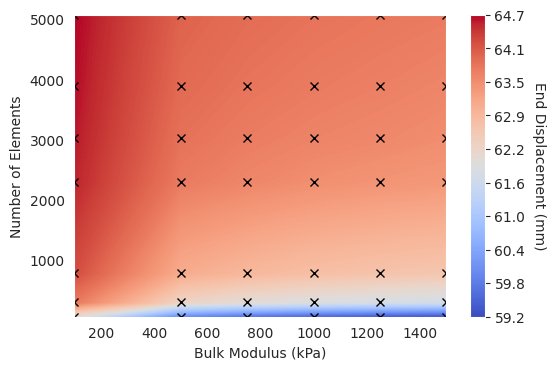

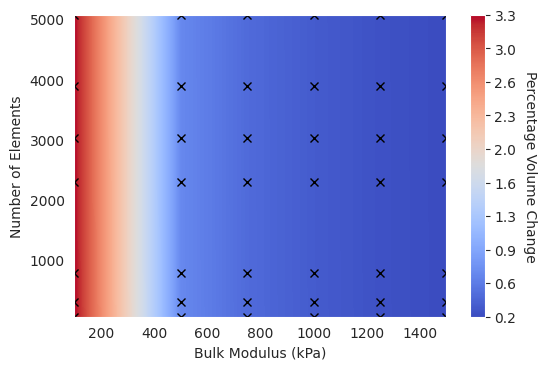

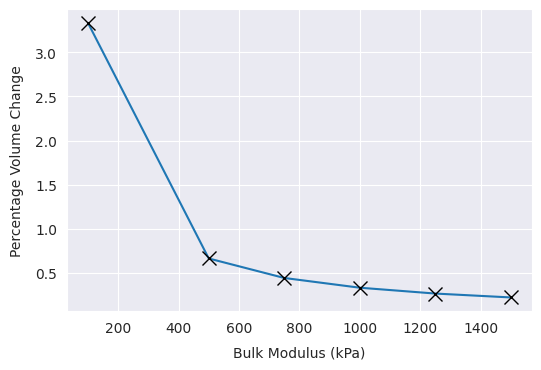

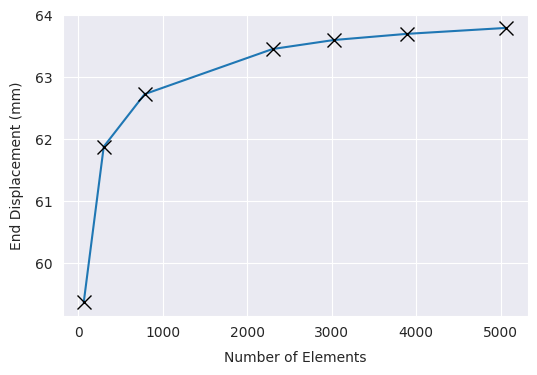

In [56]:
with open('normal_nonlinear_convergence_kappa&meshsize.json', 'r') as f:
    data = json.load(f)
plot_convergence_contours(data, y_axis='num_elem')
plot_convergence_lines_kappa_and_mesh(data)

Given that the effect of kappa appears to be independent of element size, let's now vary E and kappa:

In [60]:
elem_size = W/3
kappa_list = [100, 500, 750, 1000, 1250, 1500]
E_list = [x for x in np.linspace(10, 40, 7)]
convergence_results = \
    convergence_study_kappa_and_E(E_list, kappa_list, elem_size, nu, rot_y, rot_x, W, L, rho, g, num_steps)
with open('normal_nonlinear_convergence_kappa&E.json', 'w') as f:
    json.dump(convergence_results, f, indent=4)

Simulating Mesh 1/42 (Kappa = 100, E = 10.0)
Performing load step 1/20
Performing load step 5/20
Performing load step 10/20
Performing load step 15/20
Performing load step 20/20
Simulating Mesh 2/42 (Kappa = 100, E = 15.0)
Performing load step 1/20
Performing load step 5/20
Performing load step 10/20
Performing load step 15/20
Performing load step 20/20
Simulating Mesh 3/42 (Kappa = 100, E = 20.0)
Performing load step 1/20
Performing load step 5/20
Performing load step 10/20
Performing load step 15/20
Performing load step 20/20
Simulating Mesh 4/42 (Kappa = 100, E = 25.0)
Performing load step 1/20
Performing load step 5/20
Performing load step 10/20
Performing load step 15/20
Performing load step 20/20
Simulating Mesh 5/42 (Kappa = 100, E = 30.0)
Performing load step 1/20
Performing load step 5/20
Performing load step 10/20
Performing load step 15/20
Performing load step 20/20
Simulating Mesh 6/42 (Kappa = 100, E = 35.0)
Performing load step 1/20
Performing load step 5/20
Performing lo

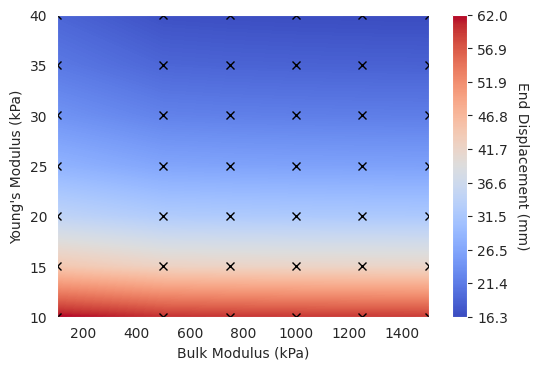

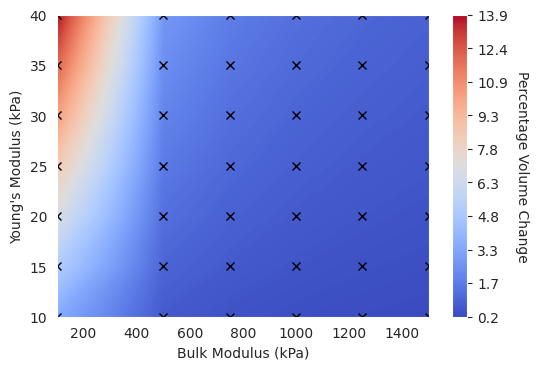

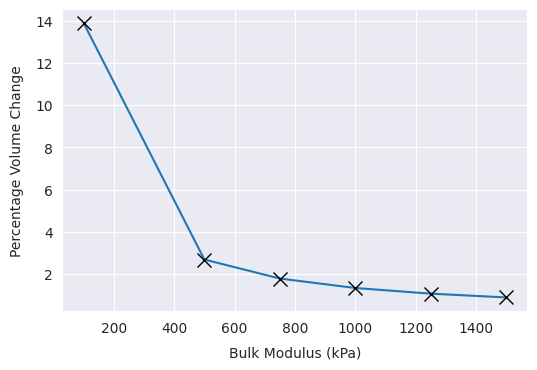

In [61]:
with open('normal_nonlinear_convergence_kappa&E.json', 'r') as f:
    data = json.load(f)
plot_convergence_contours(data, y_axis='E')
plot_convergence_lines_kappa_and_E(data)

# Generate Data

## Function Definitions

### Main Subroutine

In [12]:
def create_data(E_list, y_rot_list, x_rot_list, nu, kappa, W, L, NL, NW, rho, g, num_steps):
    
    mesh = create_mesh(L, W, NL, NW)  
    num_elem = NL * NW * NW
    
    # Get all possible combinations of parameters:
    param_combos = create_param_combos(E=E_list, y_rot=y_rot_list, x_rot=x_rot_list)
    results = {key: [] for key in ('E', 'y_rot', 'x_rot', 'disp', 'end_disp', 'time', 'volume')}
    
    for i, params in enumerate(param_combos):
        
        # Extract i'th set of parameters:
        E, y_rot, x_rot = params['E'], params['y_rot'], params['x_rot']
        print(f"Simulating Mesh {i+1}/{len(param_combos)} (E = {E}, y_rot = {y_rot}, x_rot = {x_rot})")
        
        # Compute displacement of beam:
        t_start = time.time()
        u, volumes = solve_nonlinear_problem(mesh, y_rot, x_rot, E, kappa, nu, rho, g, num_steps)
        t_end = time.time()
        t_solve = t_end - t_start
        
        print(f'Simulation took {t_solve/60:.2f} mins.\n')
        
        # Get displacement field:
        disp = u.compute_point_values().real
        
        # Compute displacement at very end of beam:
        end_disp = get_end_displacement(u, mesh, W, L)
        
        # Save results:
        results['time'].append(t_solve)
        results['volume'].append(volumes)
        results['disp'].append(disp.tolist())
        results['end_disp'].append(end_disp)
        results['E'].append(E)
        results['y_rot'].append(y_rot)
        results['x_rot'].append(x_rot)
    
    # ALso save other simulation quantities:
    coords = mesh.geometry.x
    results['coords'] = coords.tolist()
    results['nu'] = nu
    results['density'] = rho
    results['W'] = W
    results['L'] = L
    results['num_steps'] = num_steps
    results['NL'] = NL
    results['NW'] = NW
    results['num_elem'] = num_elem
    results['bulk_modulus'] = kappa
    results['rho'] = rho
    
    return results

### Plotting Function

In [9]:
def plot_data(data, convert_modulus=False, num_levels=100, E_lims=None, angle_lims=None, y_lims=None, fix_angle=('x_rot', 0)):
    
    fix_ang, fix_val = fix_angle[0], fix_angle[1]
    plot_ang = [x for x in ('x_rot', 'y_rot') if x!=fix_ang][0]
    
    fix_rot = np.array(data[fix_ang])
    mask = fix_rot == fix_val
    
    angle, E, y = np.array(data[plot_ang]), np.array(data['E']), np.array(data['end_disp'])
    
    if convert_modulus:
        nu = data['nu']
        E = (E/(2*(1 + nu)))/2
        x_label = "Neo-Hookean Stiffness (kPa)"
    else:
        x_label = "Young's Modulus (kPa)"
    
    if y_lims is None:
        y_lims = (y.min(), y.max())
        
    levels = np.linspace(y_lims[0], y_lims[1], num_levels)
    
    grid_shape = [np.unique(x).size for x in (angle, E)]
    
    # Create surface plot:
    fig, ax = plt.subplots()
    contour_fig = ax.contourf(E.reshape(grid_shape), angle.reshape(grid_shape), y.reshape(grid_shape), 
                              levels=levels, cmap=cm.coolwarm)
    ticks = np.linspace(y_lims[0], y_lims[1], 10)
    cbar = fig.colorbar(contour_fig, ticks=ticks)
    cbar.ax.set_yticklabels(['{:.0f}'.format(x) for x in ticks])
    cbar.set_label('Displacement (mm)', rotation=270, labelpad=15)
    ax.set_xlabel(x_label)
    axis_name = 'y' if fix_ang=='x_rot' else 'x'
    ax.set_ylabel(f'Rotation about {axis_name} axis (degrees)')
    ax.set_xlim(E_lims)
    ax.set_ylim(angle_lims)
    plt.plot(E, angle, 'x', color='black', markersize=6)
    fig.patch.set_facecolor('white')
    plt.show()

## Function Calls

### Define fixed values

In [14]:
# Fixed values:
nu = 0.33 # dimensionless
rho = 0.00102 # in g mm^-3
g = 9.81 # in m s^-2
W = 40 # in mm
L = 90 # in mm
num_steps = 20

In [15]:
# Compute mesh parameters:
elem_size = W/10
NL, NW = ceil(L/elem_size), ceil(W/elem_size)
# Kappa to enforce incompressibility:
kappa = 1250

### Generate and Plot Training Data

In [16]:
# First create training data:
num_pts = 10
min_E, max_E = 10, 40
min_y_rot, max_y_rot = 0, 180
min_x_rot, max_x_rot = 0, 90
E_list = [E for E in np.linspace(min_E, max_E, num_pts)]
y_rot_list = [y for y in np.linspace(min_y_rot, max_y_rot, num_pts)]
# num_pts_x = int(num_pts/2)
# x_rot_list = [x for x in np.linspace(min_x_rot, max_x_rot, num_pts_x)]
x_rot_list = [0]

training_results = create_data(E_list, y_rot_list, x_rot_list, nu, kappa, W, L, NL, NW, rho, g, num_steps)

# Save dictionary to JSON file:
with open("normal_nonlinear_train.json", 'w') as f:
    json.dump(training_results, f, indent=4)

Simulating Mesh 1/100 (E = 10.0, y_rot = 0.0, x_rot = 0)


KeyboardInterrupt: 

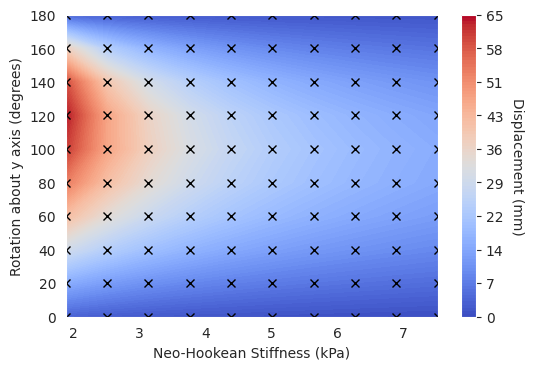

In [10]:
with open('normal_nonlinear_train.json', 'r') as f:
    data = json.load(f)
plot_data(data, y_lims=[0, 65], convert_modulus=True)

### Generate and Plot Test Data

In [22]:
# Next create test data:
delta_E = (max_E-min_E)/(num_pts-1)
delta_y_rot = (max_y_rot-min_y_rot)/(num_pts-1)
E_list = [E for E in np.linspace(min_E+0.5*delta_E, max_E-0.5*delta_E, num_pts-1)]
y_rot_list = [angle for angle in np.linspace(min_y_rot+0.5*delta_y_rot, max_y_rot-0.5*delta_y_rot, num_pts-1)]
# delta_x_rot = (max_x_rot-min_x_rot)/(num_pts_x-1)
# x_rot_list = [angle for angle in np.linspace(min_x_rot+0.5*delta_x_rot, max_x_rot-0.5*delta_x_rot, num_pts_x-1)]
x_rot_list = [0]

test_results = create_data(E_list, y_rot_list, x_rot_list, nu, kappa, W, L, NL, NW, rho, g, num_steps)

# Save dictionary to JSON file:
with open("normal_nonlinear_test.json", 'w') as f:
    json.dump(test_results, f, indent=4)

Simulating Mesh 1/81 (E = 11.666666666666666, y_rot = 10.0, x_rot = 0)
Performing load step 1/20
Performing load step 5/20
Performing load step 10/20
Performing load step 15/20
Performing load step 20/20
Simulation took 4.70 mins.

Simulating Mesh 2/81 (E = 11.666666666666666, y_rot = 30.0, x_rot = 0)
Performing load step 1/20
Performing load step 5/20
Performing load step 10/20
Performing load step 15/20
Performing load step 20/20
Simulation took 5.30 mins.

Simulating Mesh 3/81 (E = 11.666666666666666, y_rot = 50.0, x_rot = 0)
Performing load step 1/20
Performing load step 5/20


KeyboardInterrupt: 

In [ ]:
with open('normal_nonlinear_test.json', 'r') as f:
    data = json.load(f)
plot_data(data, y_lims=[0, 65])